In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
import joblib
import time
from datetime import datetime
import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
input_file = '/Users/hzy/Desktop/nus/5208/pj1/nytaxi2022.csv' 
nparts = 8
outdir = '/Users/hzy/Desktop/nus/5208/pj1/try'
embedding_dim = 8
random_state = 123

# define the cols
time_cols = ["tpep_pickup_datetime", "tpep_dropoff_datetime"]
high_cardinality_id_cols = ["PULocationID", "DOLocationID"]
low_cardinality_cat_cols = ["RatecodeID", "payment_type", "passenger_count"]
numeric_cols = [ "trip_distance", "extra"]
target_col = "total_amount"

use_cols = time_cols + high_cardinality_id_cols + low_cardinality_cat_cols + numeric_cols + [target_col]

os.makedirs(outdir, exist_ok=True)

In [3]:
print("reading___")
start_time = time.time()

df = pd.read_csv(input_file, usecols=use_cols, low_memory=False)
print(f"data_shape is: {df.shape}")

# Drop Missing values
df = df.dropna(subset=numeric_cols + high_cardinality_id_cols + low_cardinality_cat_cols + [target_col])

# Handle all category columns and change into float numbers
for col in high_cardinality_id_cols + low_cardinality_cat_cols:
    if col in df.columns:
        df[col] = df[col].astype(float).astype(int).astype(str)

# time to datetime
df["tpep_pickup_datetime"] = pd.to_datetime(
    df["tpep_pickup_datetime"], 
    format="%m/%d/%Y %I:%M:%S %p",
    errors="coerce"
)
df["tpep_dropoff_datetime"] = pd.to_datetime(
    df["tpep_dropoff_datetime"], 
    format="%m/%d/%Y %I:%M:%S %p",
    errors="coerce"
)

df = df.dropna(subset=["tpep_pickup_datetime", "tpep_dropoff_datetime"])

# Calculate the travel seconds and make sure it's at least 1 second
df["trip_duration"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds().clip(lower=1)
print(f"data shape after processing: {df.shape}")

reading___
data_shape is: (39656098, 10)
data shape after processing: (38287795, 11)


In [4]:
df1 = df.copy()
print(df1.info())

# View the statistical description of the numeric columns
print(df1[numeric_cols + [target_col]].describe())

# View the number of unique values in the category type columns
for col in high_cardinality_id_cols + low_cardinality_cat_cols:
    print(f"{col} unique values: {df1[col].nunique()}")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38287795 entries, 0 to 39529634
Data columns (total 11 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[ns]
 1   tpep_dropoff_datetime  datetime64[ns]
 2   passenger_count        object        
 3   trip_distance          float64       
 4   RatecodeID             object        
 5   PULocationID           object        
 6   DOLocationID           object        
 7   payment_type           object        
 8   extra                  float64       
 9   total_amount           float64       
 10  trip_duration          float64       
dtypes: datetime64[ns](2), float64(4), object(5)
memory usage: 3.4+ GB
None
       trip_distance         extra  total_amount
count   3.828780e+07  3.828780e+07  3.828780e+07
mean    3.514399e+00  1.040985e+00  2.142373e+01
std     5.643246e+01  1.271069e+00  9.801355e+01
min     0.000000e+00 -2.218000e+01 -2.567800e+03
25%  

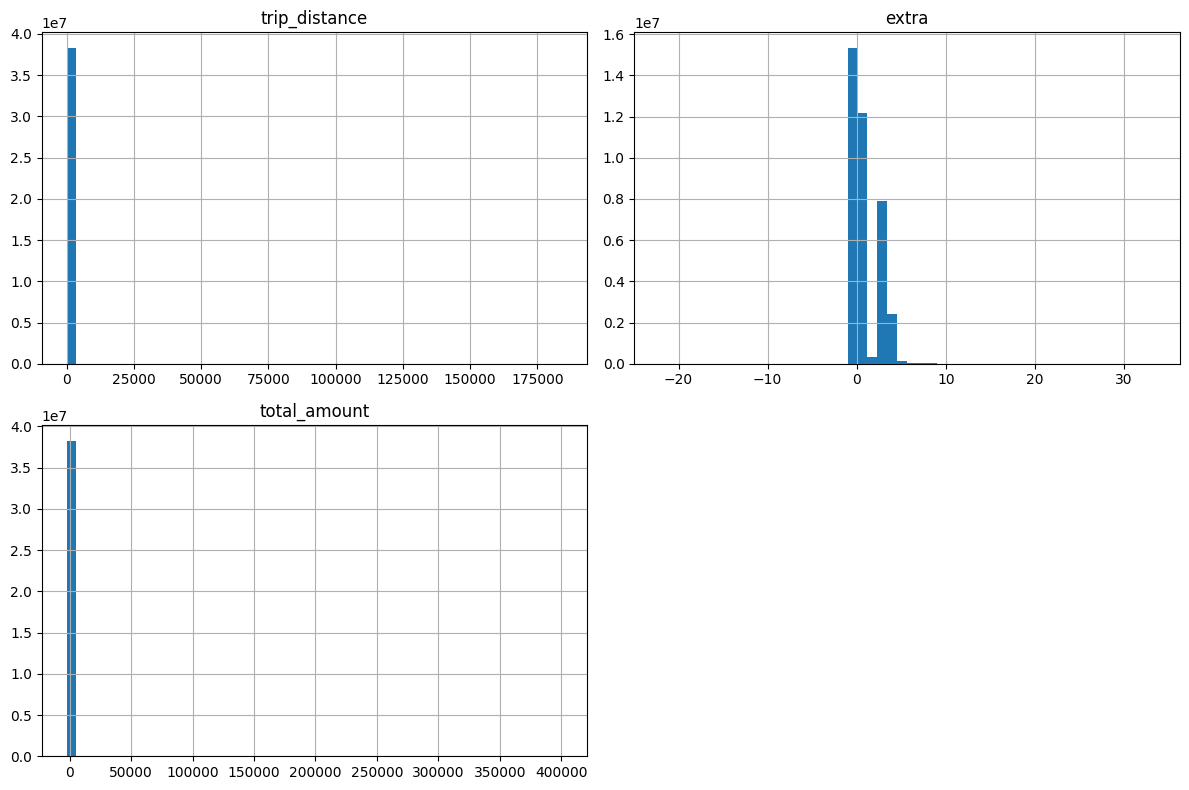

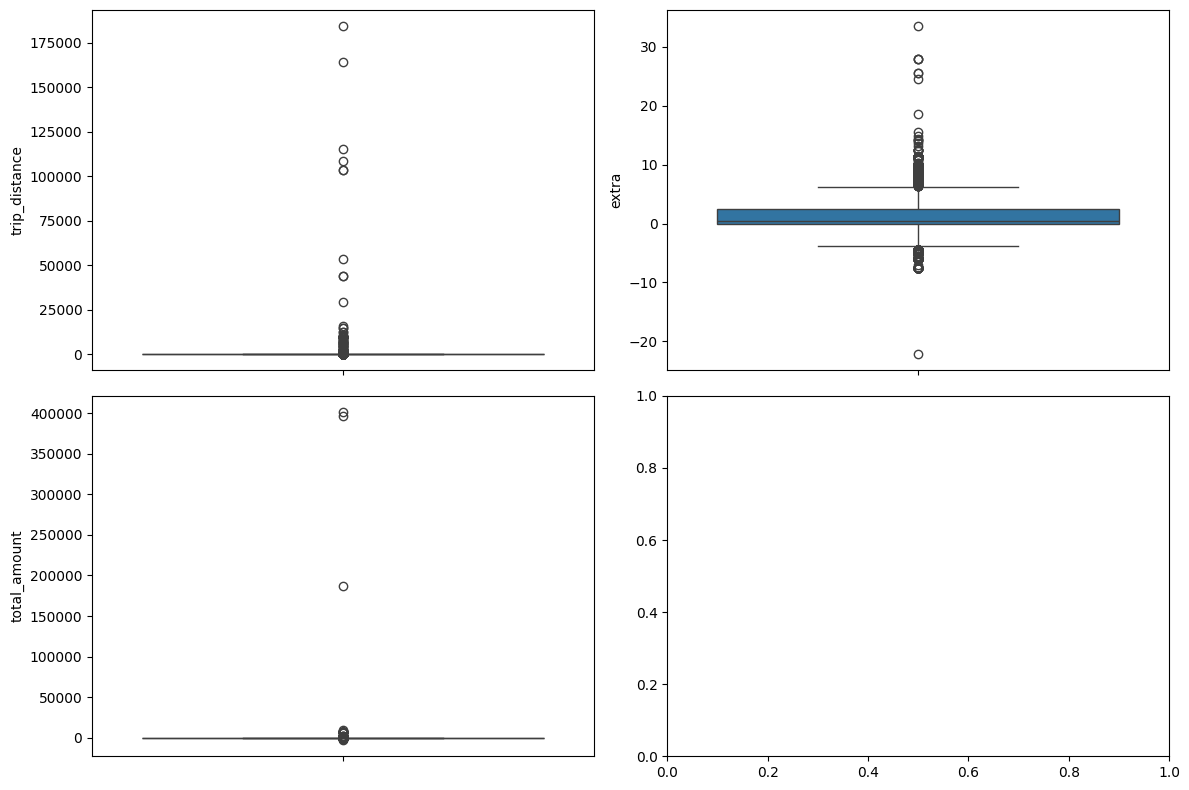

In [5]:
# Create histograms for numeric columns
df1[numeric_cols + [target_col]].hist(bins=50, figsize=(12, 8))
plt.tight_layout()
plt.show()

# boxplot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, col in enumerate(numeric_cols + [target_col]):
    sns.boxplot(data=df1, y=col, ax=axes[i//2, i%2])
plt.tight_layout()
plt.show()

In [6]:
# View the specific distribution of each category variable
category_cols = high_cardinality_id_cols + low_cardinality_cat_cols + ["passenger_count"]

for col in category_cols:
    print(f"\n=== {col} Distribution ===")
    value_counts = df[col].value_counts(dropna=False).sort_index()
    print(value_counts)
    print(f"Total amount: {value_counts.sum()}")
    
    # Calculate percent
    percentages = value_counts / value_counts.sum() * 100
    print("percent:")
    for idx, val in value_counts.items():
        print(f"  {idx}: {val} ({percentages[idx]:.2f}%)")


=== PULocationID Distribution ===
1       10088
10      13682
100    634111
101       655
102       566
        ...  
95       4009
96        107
97      13711
98        417
99         19
Name: PULocationID, Length: 262, dtype: int64
Total amount: 38287795
percent:
  1: 10088 (0.03%)
  10: 13682 (0.04%)
  100: 634111 (1.66%)
  101: 655 (0.00%)
  102: 566 (0.00%)
  105: 14 (0.00%)
  106: 1490 (0.00%)
  107: 900457 (2.35%)
  108: 800 (0.00%)
  109: 50 (0.00%)
  11: 515 (0.00%)
  111: 40 (0.00%)
  112: 5786 (0.02%)
  113: 501633 (1.31%)
  114: 457272 (1.19%)
  115: 50 (0.00%)
  116: 33345 (0.09%)
  117: 1411 (0.00%)
  118: 148 (0.00%)
  119: 1810 (0.00%)
  12: 16338 (0.04%)
  120: 203 (0.00%)
  121: 982 (0.00%)
  122: 497 (0.00%)
  123: 639 (0.00%)
  124: 891 (0.00%)
  125: 191785 (0.50%)
  126: 599 (0.00%)
  127: 2192 (0.01%)
  128: 182 (0.00%)
  129: 8917 (0.02%)
  13: 218070 (0.57%)
  130: 4816 (0.01%)
  131: 1075 (0.00%)
  132: 1909945 (4.99%)
  133: 974 (0.00%)
  134: 3622 (0.01%)
 

In [7]:
df_clean = df1.copy()

# Process trip duration
before = len(df_clean)
df_clean = df_clean[(df_clean['trip_duration'] > 30) & (df_clean['trip_duration'] < 24*60*60)]
removed = before - len(df_clean)
print(f"Remove 'trip_duration' outliers: {removed} ({removed/before:.2%})")

# Process invalid category values
df_clean['passenger_count'] = pd.to_numeric(df_clean['passenger_count'], errors='coerce')
df_clean['RatecodeID'] = pd.to_numeric(df_clean['RatecodeID'], errors='coerce')
df_clean['payment_type'] = pd.to_numeric(df_clean['payment_type'], errors='coerce')
before = len(df_clean)
df_clean.loc[~df_clean['RatecodeID'].isin([1,2,3,4,5,99]), 'RatecodeID'] = np.nan
df_clean.loc[~df_clean['payment_type'].isin([1,2,3,4]), 'payment_type'] = np.nan
df_clean.loc[(df_clean['passenger_count'] == 0) | (df_clean['passenger_count'] > 6), 'passenger_count'] = np.nan
df_clean = df_clean.dropna()
removed = before - len(df_clean)
print(f"Remove categorical outliers: {removed}  ({removed/before:.2%})")

# Filters principle
numeric_filters = {
    'trip_distance': (0.1, 100),     
    'extra': (0, 10),                
    'total_amount': (2, 1000),       
}

# Apply numerical filtering
for col, (min_val, max_val) in numeric_filters.items():
    before = len(df_clean)
    df_clean = df_clean[(df_clean[col] >= min_val) & (df_clean[col] <= max_val)]
    removed = before - len(df_clean)
    print(f"Remove {col} Outlier Value: {removed}  ({removed/before:.2%})")

# Check the shape of the cleaned data
print(f"Original shape: {df1.shape}")
print(f"Cleaned shape: {df_clean.shape}")

Remove 'trip_duration' outliers: 414658 (1.08%)
Remove categorical outliers: 749349  (1.98%)
Remove trip_distance Outlier Value: 250416  (0.67%)
Remove extra Outlier Value: 95991  (0.26%)
Remove total_amount Outlier Value: 98619  (0.27%)
Original shape: (38287795, 11)
Cleaned shape: (36678762, 11)


In [8]:
print(df_clean[numeric_cols + [target_col]].describe())

# View the number of unique values in the category type column
for col in high_cardinality_id_cols + low_cardinality_cat_cols:
    print(f"{col} unique values: {df_clean[col].nunique()}")

       trip_distance         extra  total_amount
count   3.667876e+07  3.667876e+07  3.667876e+07
mean    3.538695e+00  1.025319e+00  2.145346e+01
std     4.483307e+00  1.253776e+00  1.674381e+01
min     1.000000e-01  0.000000e+00  2.000000e+00
25%     1.140000e+00  0.000000e+00  1.230000e+01
50%     1.900000e+00  5.000000e-01  1.596000e+01
75%     3.540000e+00  2.500000e+00  2.256000e+01
max     9.989000e+01  1.000000e+01  8.996800e+02
PULocationID unique values: 262
DOLocationID unique values: 262
RatecodeID unique values: 6
payment_type unique values: 4
passenger_count unique values: 6


In [9]:
# seperate the training set and the test set
train_df, test_df = train_test_split(df_clean, test_size=0.3, random_state=random_state)
print(f"shape of train set: {train_df.shape}, shape of test set: {test_df.shape}")

shape of train set: (25675133, 11), shape of test set: (11003629, 11)


In [10]:
# Collect the category mapping of the training set
category_mappings = {}
for col in high_cardinality_id_cols + low_cardinality_cat_cols:
    category_mappings[col] = sorted(train_df[col].dropna().unique())

# Calculate the statistics of the numerical features of the training set

numeric_global_stats = {}
for col in numeric_cols + ["trip_duration", target_col]:
    numeric_global_stats[col] = {
        'mean': train_df[col].mean(),
        'std': train_df[col].std(),
        'min': train_df[col].min(),
        'max': train_df[col].max()
    }
numeric_global_stats

{'trip_distance': {'mean': 3.5388405668628775,
  'std': 4.483901516566026,
  'min': 0.1,
  'max': 99.44},
 'extra': {'mean': 1.0252099889803992,
  'std': 1.25377242554256,
  'min': 0.0,
  'max': 10.0},
 'trip_duration': {'mean': 1047.0145965748259,
  'std': 2952.2278924324046,
  'min': 31.0,
  'max': 86398.0},
 'total_amount': {'mean': 21.453234607976487,
  'std': 16.74002051914007,
  'min': 2.05,
  'max': 855.8}}

In [11]:
# Create Category Encoders (Only for High Cardinality features)
label_encoders = {}
for col in high_cardinality_id_cols:
    le = LabelEncoder()
    le.fit(list(category_mappings[col]))
    label_encoders[col] = le
    joblib.dump(le, os.path.join(outdir, f"label_encoder_{col}.pkl"))

# Create one-hot encoding mappings for low-cardinality features
one_hot_mappings = {}
for col in low_cardinality_cat_cols:
    categories = sorted(list(category_mappings[col]))
    one_hot_mappings[col] = categories
    joblib.dump(categories, os.path.join(outdir, f"one_hot_categories_{col}.pkl"))

print(f"dimensions of various categories:")
for col in high_cardinality_id_cols:
    print(f"  {col}: {len(category_mappings[col])} categories (using embedding)")
for col in low_cardinality_cat_cols:
    print(f"  {col}: {len(category_mappings[col])} categories (using one-hot)")

dimensions of various categories:
  PULocationID: 262 categories (using embedding)
  DOLocationID: 262 categories (using embedding)
  RatecodeID: 6 categories (using one-hot)
  payment_type: 4 categories (using one-hot)
  passenger_count: 6 categories (using one-hot)


In [12]:
# Create a random Embedding matrix for high-cardinality features
print("Create Embedding matrix...")
embedding_matrices = {}
for col in high_cardinality_id_cols:
    vocab_size = len(category_mappings[col])
    embedding_matrix = np.random.normal(0, 0.1, (vocab_size, embedding_dim)).astype(np.float32)
    embedding_matrices[col] = embedding_matrix
    np.save(os.path.join(outdir, f"embedding_{col}.npy"), embedding_matrix)


Create Embedding matrix...


In [13]:
# process test and train data
def process_data(df):
    # Standardized Numerical Classes
    # Use statistical information from the training set
    for col in numeric_cols + ["trip_duration", target_col]:
        if col in df.columns:
            mean, std = numeric_global_stats[col]['mean'], numeric_global_stats[col]['std']
            df[col] = (df[col] - mean) / (std if std > 0 else 1)
    
    # Perform Embedding search on high-cardinality category columns
    embedding_features = []
    for col in high_cardinality_id_cols:
        if col in df.columns:
            # If there are unseen categories - Map to 0
            encoded = np.zeros(len(df), dtype=int)
            known_categories = set(label_encoders[col].classes_)
            mask = df[col].isin(known_categories)
            encoded[mask] = label_encoders[col].transform(df.loc[mask, col])
            embeddings = embedding_matrices[col][encoded]
            embedding_features.append(embeddings)
    
    # one-hot encoding for low-cardinality category columns
    one_hot_features = []
    for col in low_cardinality_cat_cols:
        if col in df.columns:
            one_hot = np.zeros((len(df), len(one_hot_mappings[col])))
            for j, category in enumerate(one_hot_mappings[col]):
                one_hot[:, j] = (df[col] == category).astype(float)
            one_hot_features.append(one_hot)
    
    numeric_features = df[numeric_cols].values
    time_feature = df['trip_duration'].values.reshape(-1, 1)
    
    all_features_list = [numeric_features, time_feature]
    if embedding_features:
        all_features_list.extend(embedding_features)
    if one_hot_features:
        all_features_list.extend(one_hot_features)
    
    all_features = np.hstack(all_features_list)
    labels = df[target_col].values.reshape(-1, 1)
    
    return all_features, labels

X_train, y_train = process_data(train_df)
X_test, y_test = process_data(test_df)

In [14]:
feature_cols = []
# Numeric
feature_cols.extend(numeric_cols)
# Time
feature_cols.append('trip_duration')
# Embedding
for col in high_cardinality_id_cols:
    for i in range(embedding_dim):
        feature_cols.append(f"{col}_embed_{i}")
# One-hot
for col in low_cardinality_cat_cols:
    for category in one_hot_mappings[col]:
        feature_cols.append(f"{col}_{category}")

train_files = {i: open(os.path.join(outdir, f"train_part_{i}.csv"), 'w') for i in range(nparts)}
test_files = {i: open(os.path.join(outdir, f"test_part_{i}.csv"), 'w') for i in range(nparts)}

header = feature_cols + ['label']

for i in range(nparts):
    train_files[i].write(','.join(header) + '\n')
    test_files[i].write(','.join(header) + '\n')

train_data = np.hstack([X_train, y_train])
np.random.shuffle(train_data) 

# Send test data to partitions
# Calculate how many rows each partition should have (discard the remainder)
train_rows_per_part = len(train_data) // nparts
train_data = train_data[:train_rows_per_part * nparts] 

for j in range(nparts):
    start_idx = j * train_rows_per_part
    end_idx = (j + 1) * train_rows_per_part
    
    # 分配数据到分区
    partition_data = train_data[start_idx:end_idx]
    np.savetxt(train_files[j], partition_data, delimiter=',', fmt='%.6f')

# Send test data to partitions
test_data = np.hstack([X_test, y_test])
np.random.shuffle(test_data)

test_rows_per_part = len(test_data) // nparts
test_data = test_data[:test_rows_per_part * nparts] 

for j in range(nparts):
    start_idx = j * test_rows_per_part
    end_idx = (j + 1) * test_rows_per_part
    
    partition_data = test_data[start_idx:end_idx]
    np.savetxt(test_files[j], partition_data, delimiter=',', fmt='%.6f')

for f in train_files.values():
    f.close()
for f in test_files.values():
    f.close()

# Save metadata
metadata = {
    'input_size': len(feature_cols),
    'numeric_cols': numeric_cols,
    'high_cardinality_id_cols': high_cardinality_id_cols,
    'low_cardinality_cat_cols': low_cardinality_cat_cols,
    'time_cols': ['trip_duration'],
    'numeric_stats': numeric_global_stats,
    'category_sizes': {col: len(category_mappings[col]) for col in high_cardinality_id_cols + low_cardinality_cat_cols},
    'embedding_dim': embedding_dim,
    'one_hot_categories': one_hot_mappings,
    'total_processed': len(df),
    'total_dropped': len(df) - (len(train_df) + len(test_df)),
    'processing_date': datetime.now().isoformat()
}

with open(os.path.join(outdir, 'metadata.json'), 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"Total lines: {len(train_df) + len(test_df)}")
print(f"Total dropped rows: {len(df) - (len(train_df) + len(test_df))}")
print(f"Input feature dimension: {len(feature_cols)}")
print(f"  - Numerical features: {len(numeric_cols)}")
print(f"  - Time features: 1")
print(f"  - Embedding features: {len(high_cardinality_id_cols) * embedding_dim}")
print(f"  - One-hot features: {sum(len(categories) for categories in one_hot_mappings.values())}")
print(f"Data saved to directory: {outdir}")
print(f"Generated files:")
print(f"  - train_part_*.csv: Training data partitions")
print(f"  - test_part_*.csv: Test data partitions")
print(f"  - embedding_*.npy: Embedding matrices (high-cardinality features)")
print(f"  - label_encoder_*.pkl: Label encoders (high-cardinality features)")
print(f"  - one_hot_categories_*.pkl: One-hot category mappings (low-cardinality features)")
print(f"  - metadata.json: Metadata information")
print(f"Training dataset length per partition: {train_rows_per_part}")
print(f"Test dataset length per partition: {test_rows_per_part}")

Total lines: 36678762
Total dropped rows: 1609033
Input feature dimension: 35
  - Numerical features: 2
  - Time features: 1
  - Embedding features: 16
  - One-hot features: 16
Data saved to directory: /Users/hzy/Desktop/nus/5208/pj1/try
Generated files:
  - train_part_*.csv: Training data partitions
  - test_part_*.csv: Test data partitions
  - embedding_*.npy: Embedding matrices (high-cardinality features)
  - label_encoder_*.pkl: Label encoders (high-cardinality features)
  - one_hot_categories_*.pkl: One-hot category mappings (low-cardinality features)
  - metadata.json: Metadata information
Training dataset length per partition: 3209391
Test dataset length per partition: 1375453
